# Contents

* Analysing topics inside data tweets.
* Chossen 100 num of topics due to the short length of tweets. 
* The higher the number of topics the the higher the specificity of the topic, 
given the small amount of words per tweet. 
* The lower the number of topics the more general the topic and less correlated to specific words. 

* In the plot we can see:
* probability distributions seems to discern a bit. However, topic 53 seems is highlu probable no mater what sentiment. 
* There are some small overlapings could be due to the number of topics chosen 

# Setup

In [1]:
import re
from collections import Counter

import pandas as pd
import numpy as np
import gensim
from gensim.models.ldamulticore import LdaMulticore

import nltk
import matplotlib.pyplot as plt

# Raw dataset

In [2]:
data = pd.read_csv('../../data/raw/tweets-train.csv')

In [3]:
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
data = data.dropna().reset_index()

In [5]:
data.isnull().sum()

index            0
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

## 1. Tokenizing / cleaning text

In [6]:
special_word = 'tweeety'

def remove_ascii_words(df, column):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    for i in range(len(df)):
        for word in df.iloc[i][column].split(' '):
            # removing chars above 128 ascii
            if any([ord(character) >= 128 for character in word]):
                # replace odd word with tweeetty 
                df.loc[i, column] = df.loc[i, column].replace(word, special_word)
    


def get_good_tokens(sentence):
    """replacing punctuation with "" empty.
    filtering empty words from replaced puctuation"""
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation


def w2v_preprocessing(df, column):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing. Not using it now but usefull in future if word embed applied. 
    """
    df['text'] = df[column].str.lower()
    df['document_sentences'] = df[column].str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentence:
                                         list(map(nltk.word_tokenize, sentence)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentence:
                                         list(map(get_good_tokens, sentence)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentence:
                                         list(filter(lambda lst: lst, sentence)),
                                         df.tokenized_sentences))  # remove empty lists

    
def lda_get_good_tokens(df, column):
    """"""
    df['tokenized_text'] = list(map(nltk.word_tokenize, df[column]))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))
    
    
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. 
    """
    stopwords = nltk.corpus.stopwords.words('english')+['tweeety']

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df.tokenized_text))
    
def stem_words(df):
    """Remove word endings using nltk lemmatizer"""
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))
    

In [7]:
def tokenizing_cleaning_tweets(df):
    remove_ascii_words(df, 'text')
    w2v_preprocessing(df, 'text')
    lda_get_good_tokens(df, 'text')
    remove_stopwords(df)
    stem_words(df)
    
tokenizing_cleaning_tweets(data)

## Vectorize words

In [8]:
def document_to_bow(df, column):
    # create dict
    dictionary = gensim.corpora.Dictionary(df[column])
    print(dictionary)
    # filtering low count 
    dictionary.filter_extremes(no_above=0.8, no_below=3)
    # Reindexes the remaining words after filtering 
    dictionary.compactify()
    print("Left with {} words.".format(len(dictionary.values())))
    # Make a BOW for every document
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    return dictionary

In [9]:
dictionary = document_to_bow(data, 'stemmed_text')

Dictionary(22016 unique tokens: ['go', 'respond', '!', 'diego', 'miss']...)
Left with 5655 words.


In [10]:
data.head()

,index,textID,text,selected_text,sentiment,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow
0,0,cb774db0d1,"i`d have responded, if i were going","I`d have responded, if I were going",neutral,"[ i`d have responded, if i were going]","[[i, d, have, responded, if, i, were, going]]","[i, d, have, responded, if, i, were, going]","[responded, going]","[responded, going]","[respond, go]","[(0, 1), (1, 1)]"
1,1,549e992a42,sooo sad i will miss you here in san diego!!!,Sooo SAD,negative,[ sooo sad i will miss you here in san diego!!!],"[[sooo, sad, i, will, miss, you, here, in, san...","[sooo, sad, i, will, miss, you, here, in, san,...","[sooo, sad, miss, san, diego, !, !, !]","[sooo, sad, miss, san, diego, !, !, !]","[sooo, sad, miss, san, diego, !, !, !]","[(2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]"
2,2,088c60f138,my boss is bullying me...,bullying me,negative,"[my boss is bullying me, , , ]","[[my, boss, is, bullying, me]]","[my, boss, is, bullying, me]","[boss, bullying]","[bos, bullying]","[bo, bulli]","[(8, 1), (9, 1)]"
3,3,9642c003ef,what interview! leave me alone,leave me alone,negative,[ what interview! leave me alone],"[[what, interview, !, leave, me, alone]]","[what, interview, !, leave, me, alone]","[interview, !, leave, alone]","[interview, !, leave, alone]","[interview, !, leav, alon]","[(2, 1), (10, 1), (11, 1), (12, 1)]"
4,4,358bd9e861,"sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"[ sons of ****, why couldn`t they put them on ...","[[sons, of, why, couldn, t, they, put, them, o...","[sons, of, why, couldn, t, they, put, them, on...","[sons, put, releases, already, bought]","[son, put, release, already, bought]","[son, put, releas, alreadi, bought]","[(13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]"


# LDA model

In [15]:
# LDA (training)
def training_lda(num_topics, corpus=data.bow, id2word=dictionary):
    #A multicore approach to decrease training time
    LDAmodel = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=num_topics,
                            workers=4,
                            chunksize=2000,
                            passes=7,
                            alpha='asymmetric')
    return LDAmodel

# LDA topic inspection
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

# Plot funcion

In [12]:
def ploting_topics_distributions(pos_topic_dist, neg_topic_dist, neu_topic_dis, *, num_topics, ylim=0.06,):
    fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,15))

    nr_top_bars = 5
    ax1.set_title("Pos sentiment distributions", fontsize=16)
    ax2.set_title("Neg sentiment distributions", fontsize=16)
    ax3.set_title("Neu sentiment distributions", fontsize=16)
    ax3.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
             rotation="vertical")

    for ax, distribution, color in zip([ax1,ax2,ax3],
                                   [pos_topic_dist,neg_topic_dist,neu_topic_dis],
                                   ['b','g','r']):
        # Individual distribution barplots
        ax.bar(range(len(distribution)), distribution, alpha=0.7)
        rects = ax.patches
        for i in np.argsort(distribution)[-nr_top_bars:]:
            rects[i].set_color(color)
            rects[i].set_alpha(1)
        # General plotting adjustments
        ax.set_xlim(-1, 50)
        ax.set_xticks(range(0, num_topics+1, 5))
        ax.set_xticklabels(range(0,num_topics+1, 5), fontsize=16)
        ax.set_ylim(0,ylim)
        ax.set_yticks([0,ylim/2,ylim])
        ax.set_yticklabels([0,ylim/2,ylim], fontsize=16)

        fig.tight_layout(h_pad=3.)


## Analysing for 100 of topics

In [16]:
LDAmodel100 = training_lda(num_topics = 100)

data['lda_features100'] = list(map(
    lambda doc: document_to_lda_features(LDAmodel100, doc),
    data.bow))

### Topics distribution

How to read the plot:
- x axes num topics classified from 0 to topics analysed
- y axes the probability of the topic found in data for the specific sentiment
- ideally high probabilities across sentiments shoun't match same topic. If so it would suggest diff to forecast those topic observations

C:\Users\Elia\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


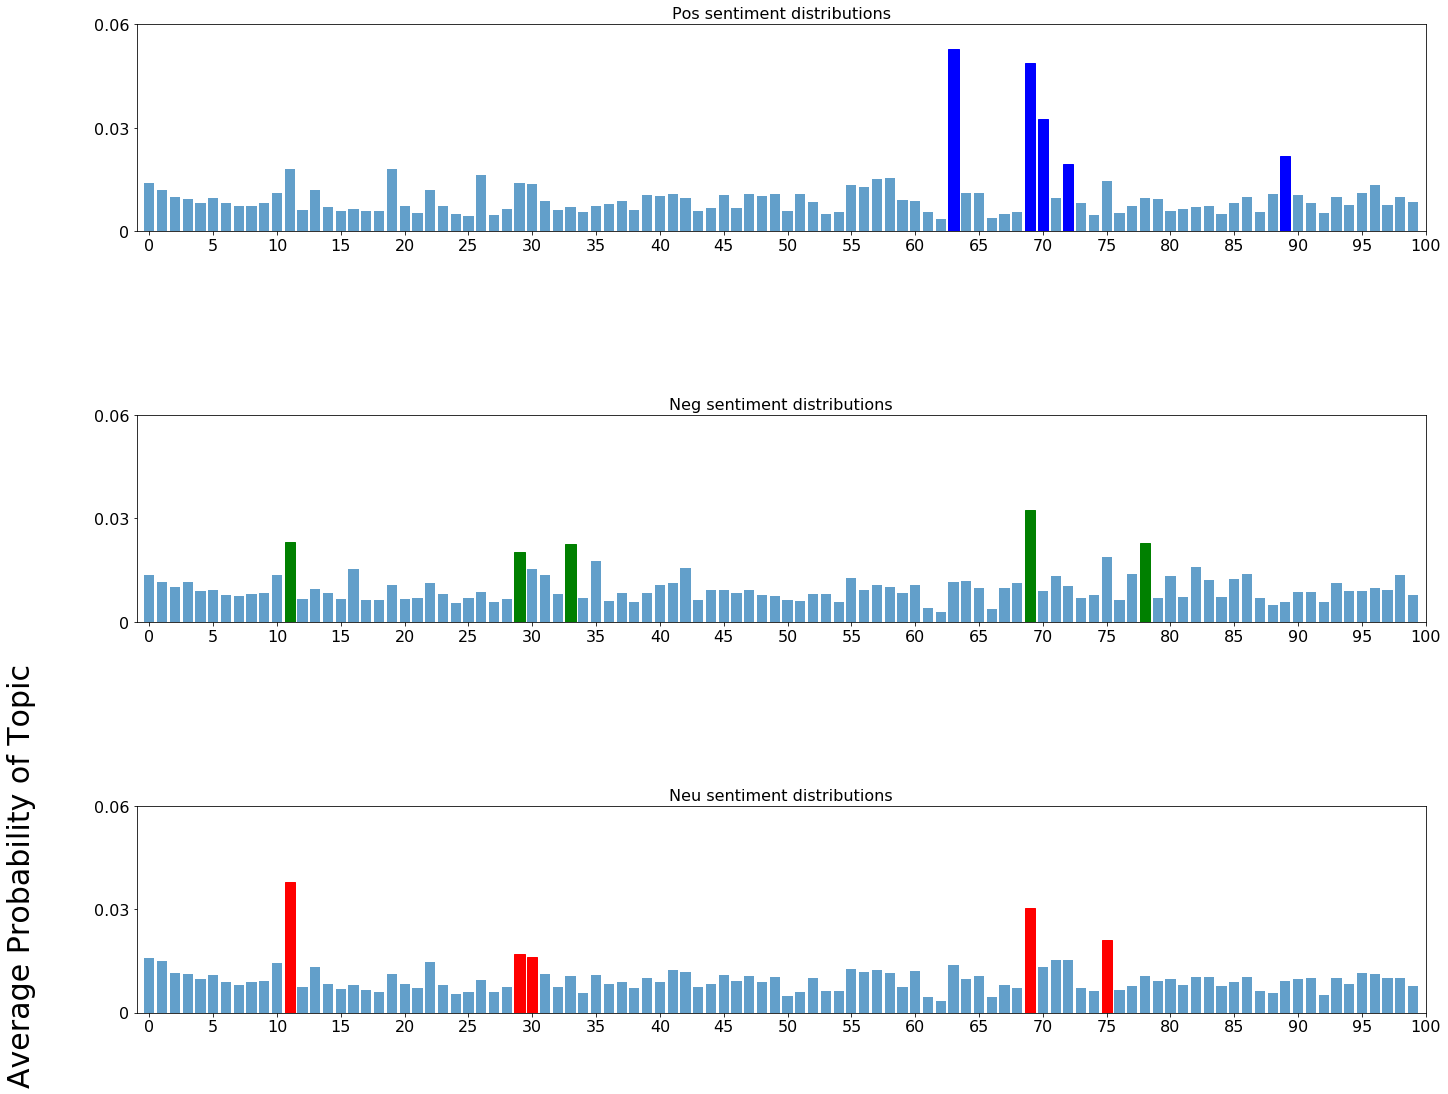

In [17]:
pos_top_dist = data.loc[data.sentiment == 'positive', 'lda_features100'].mean()
neg_top_dist = data.loc[data.sentiment == 'negative', 'lda_features100'].mean()
neu_top_dist = data.loc[data.sentiment == 'neutral', 'lda_features100'].mean()
ploting_topics_distributions(pos_top_dist, neg_top_dist, neu_top_dist, num_topics=100)

## Analysing for 60 of topics

In [18]:
LDAmodel60 = training_lda(num_topics = 60)

data['lda_features60'] = list(map(
    lambda doc: document_to_lda_features(LDAmodel60, doc),
    data.bow))

### Topics distribution

C:\Users\Elia\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


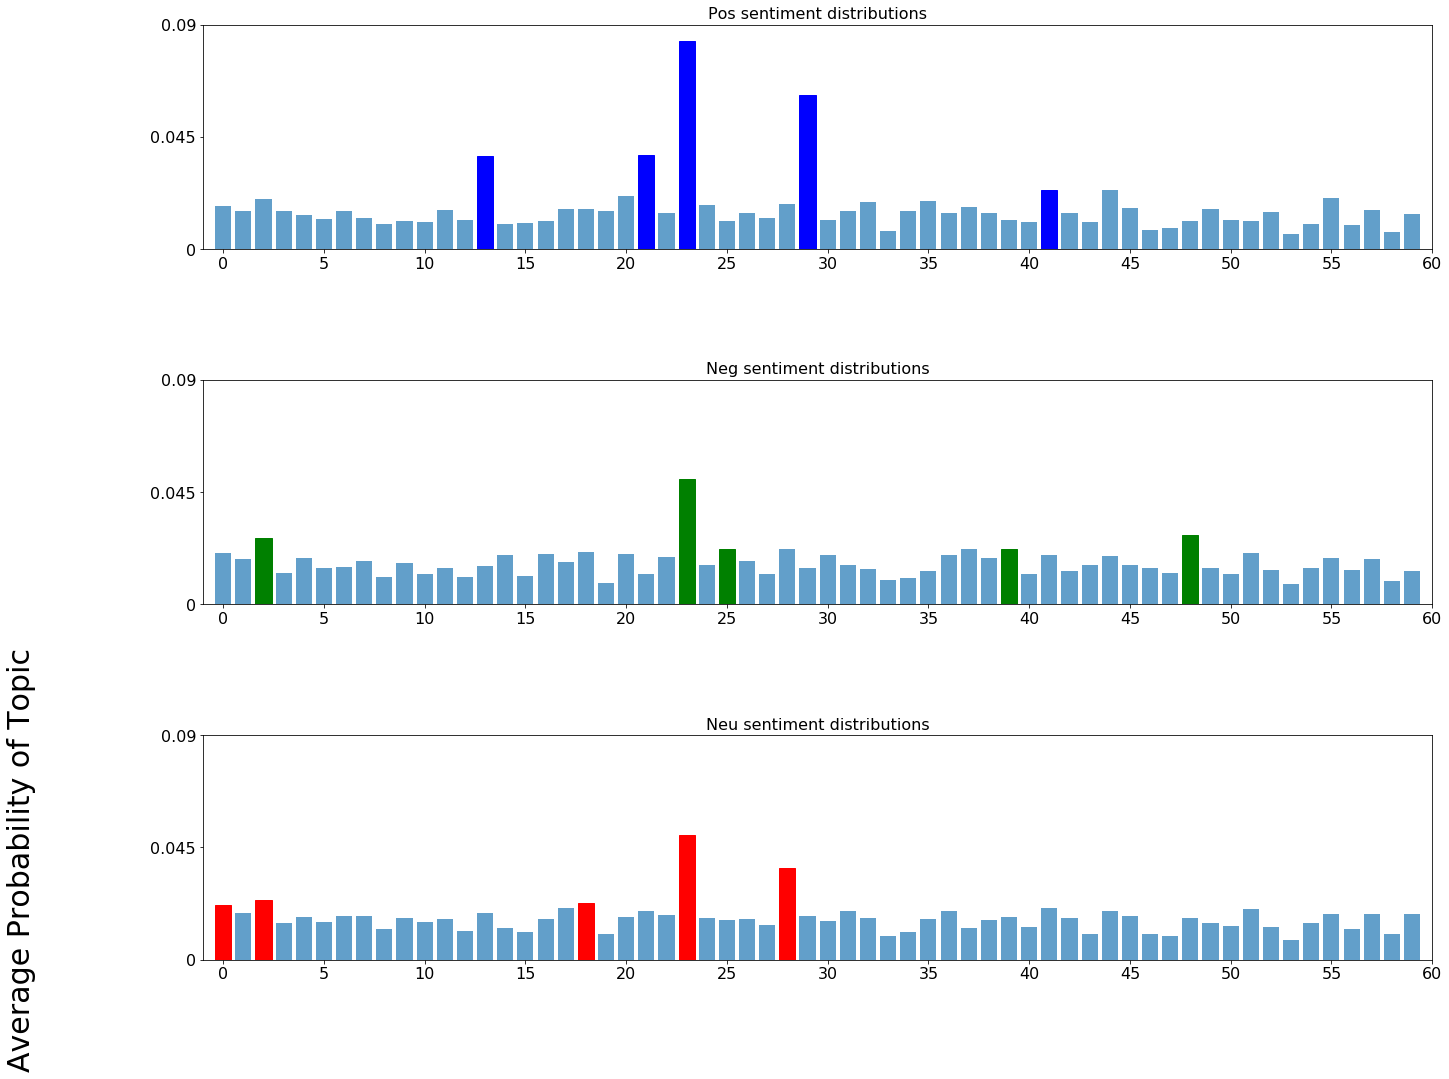

In [19]:
pos_top_dist = data.loc[data.sentiment == 'positive', 'lda_features60'].mean()
neg_top_dist = data.loc[data.sentiment == 'negative', 'lda_features60'].mean()
neu_top_dist = data.loc[data.sentiment == 'neutral', 'lda_features60'].mean()
ploting_topics_distributions(pos_top_dist, neg_top_dist, neu_top_dist, num_topics=60, ylim=0.09)